# Data Loading and Database Connection for ML Forecasting

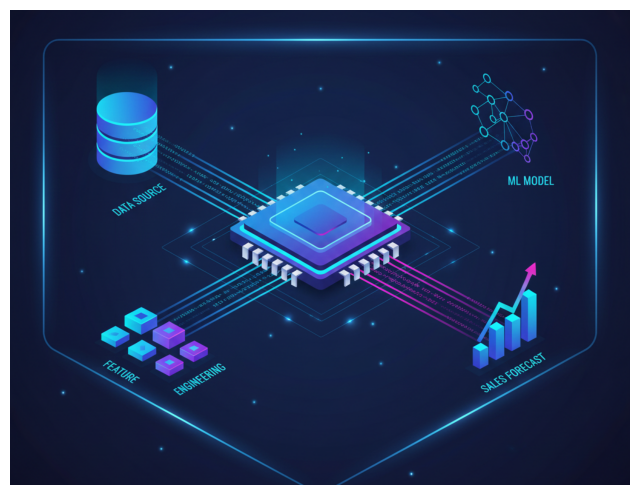

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("../images/docker_img.png")

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis("off")
plt.show()

#### This notebook connects to a Dockerized MySQL database to retrieve both coffee sales data and historical weather data. <br> It merges the datasets, prepares features for machine learning, and builds a Random Forest model to analyze and predict sales patterns.

##### Loading Weather and Sales Data from Dockerized MySQL Database


In [2]:
import os
import pandas as pd
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()

DB_NAME = os.getenv("MYSQL_DATABASE")
DB_USER = os.getenv("MYSQL_USER")
DB_PASSWORD = os.getenv("MYSQL_PASSWORD")
DB_HOST = "127.0.0.1"
DB_PORT = 3306


engine = create_engine(
    f"mysql+pymysql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)


In [3]:
coffee_sales = pd.read_sql("SELECT * FROM coffee_sales", engine)
weather_data = pd.read_sql("SELECT * FROM weather", engine)

In [4]:
coffee_sales.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,total_sales,month,hour,weekday,year_num,month_num,day_num
0,1,2023-01-01,0 days 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,6.0,2023-01,7,Sunday,2023,1,1
1,2,2023-01-01,0 days 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday,2023,1,1
2,3,2023-01-01,0 days 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,9.0,2023-01,7,Sunday,2023,1,1
3,4,2023-01-01,0 days 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2.0,2023-01,7,Sunday,2023,1,1
4,5,2023-01-01,0 days 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,6.2,2023-01,7,Sunday,2023,1,1


In [5]:
weather_data.head()

,date,avg_temp
0,2023-01-01,8.78542
1,2023-01-02,7.98125
2,2023-01-03,9.69167
3,2023-01-04,13.08130
4,2023-01-05,9.91250


#### Preparing Coffee Sales Data for ML by Selecting Important Columns

In [6]:
sales_ml = coffee_sales[ [ "day_num", "month_num", "year_num", "store_id", "total_sales", "transaction_date" ] ]

#### Aggregating Daily Sales per Store

In [7]:
daily_sales = sales_ml.groupby(
    ["transaction_date", "store_id"]
).agg({
    "total_sales": "sum",
    "year_num": "first",
    "month_num": "first",
    "day_num": "first"
}).reset_index()

daily_sales

,transaction_date,store_id,total_sales,year_num,month_num,day_num
0,2023-01-01,3,868.40,2023,1,1
1,2023-01-01,5,788.35,2023,1,1
2,2023-01-01,8,851.45,2023,1,1
3,2023-01-02,3,925.50,2023,1,2
4,2023-01-02,5,649.05,2023,1,2
...,...,...,...,...,...,...
538,2023-06-29,5,1299.45,2023,6,29
539,2023-06-29,8,1298.55,2023,6,29
540,2023-06-30,3,1807.65,2023,6,30
541,2023-06-30,5,1768.74,2023,6,30


The dataset contains **543 rows** and **6 columns**

In [8]:
daily_sales.rename(
    columns={"transaction_date": "date"},
    inplace=True
)

In [9]:
weather_data["date"] = pd.to_datetime(weather_data["date"])
daily_sales["date"] = pd.to_datetime(daily_sales["date"])

#### Merging Daily Sales with Weather Data

In [10]:
ml_df = pd.merge(
    daily_sales,
    weather_data,
    on="date",
    how="left"
)

In [11]:
ml_df.drop(columns=["date"], inplace=True)

We dropped the **date** column after merging the two datasets, as it is not needed for machine learning.

In [12]:
ml_df = ml_df[
    ['year_num', 'month_num', 'day_num', 'store_id', 'avg_temp', 'total_sales']
]

ml_df

,year_num,month_num,day_num,store_id,avg_temp,total_sales
0,2023,1,1,3,8.78542,868.40
1,2023,1,1,5,8.78542,788.35
2,2023,1,1,8,8.78542,851.45
3,2023,1,2,3,7.98125,925.50
4,2023,1,2,5,7.98125,649.05
...,...,...,...,...,...,...
538,2023,6,29,5,22.35420,1299.45
539,2023,6,29,8,22.35420,1298.55
540,2023,6,30,3,23.03960,1807.65
541,2023,6,30,5,23.03960,1768.74


The dataset is now ready for machine learning. It contains **543 rows** and **6 columns**

# Machine Learning Model – Daily Sales Prediction

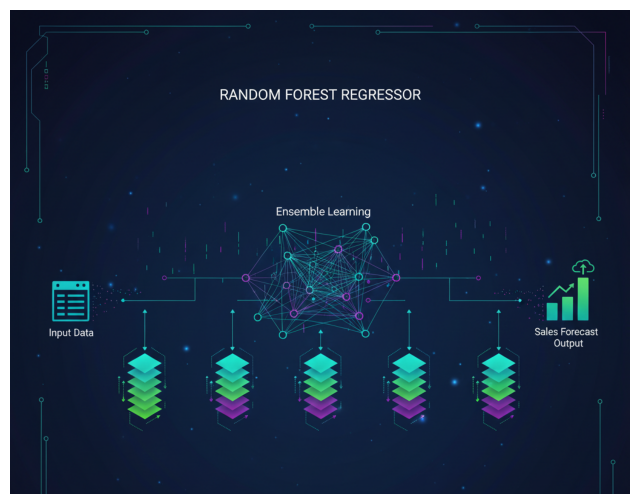

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("../images/ml_image.png")

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis("off")
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

ml_df.head()

,year_num,month_num,day_num,store_id,avg_temp,total_sales
0,2023,1,1,3,8.78542,868.40
1,2023,1,1,5,8.78542,788.35
2,2023,1,1,8,8.78542,851.45
3,2023,1,2,3,7.98125,925.50
4,2023,1,2,5,7.98125,649.05


### Feature Selection and Target Definition

In [15]:
features = ['store_id', 'year_num', 'month_num', 'day_num', 'avg_temp']
target = 'total_sales'


X = ml_df[features]
y = ml_df[target]

### Train–Test Split

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,
    test_size=0.2,
    random_state=42
)

### Model Training – Random Forest Regressor

In [17]:
rf_model = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42
)

rf_model.fit(X_train, y_train)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=1.0The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None or 1.0, then `max_features=n_features`... note:: The default of 1.0 is equivalent to bagged trees and more randomness can be achieved by setting smaller values, e.g. 0.3... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to 1.0.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",1.0
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples 

### Model Evaluation Metrics

In [18]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2 Score:", r2)


MSE: 42461.452248694615
RMSE: 206.06176804224168
R2 Score: 0.796512857386648


##### The model performs well, but it is not perfect and still makes some errors.
**🔹 R² = 0.80**

The model understands about 80% of the sales pattern

This means the model works well

It is not perfect, but it is reliable



**🔹 RMSE = 206**

On average, the model is about 200 sales units wrong

For example, if real sales are 1000, the model may predict around 800–1200

This error level is reasonable for this data



**🔹 MSE**

This is just a technical number

It is mainly used to calculate RMSE

### Feature Importance Analysis

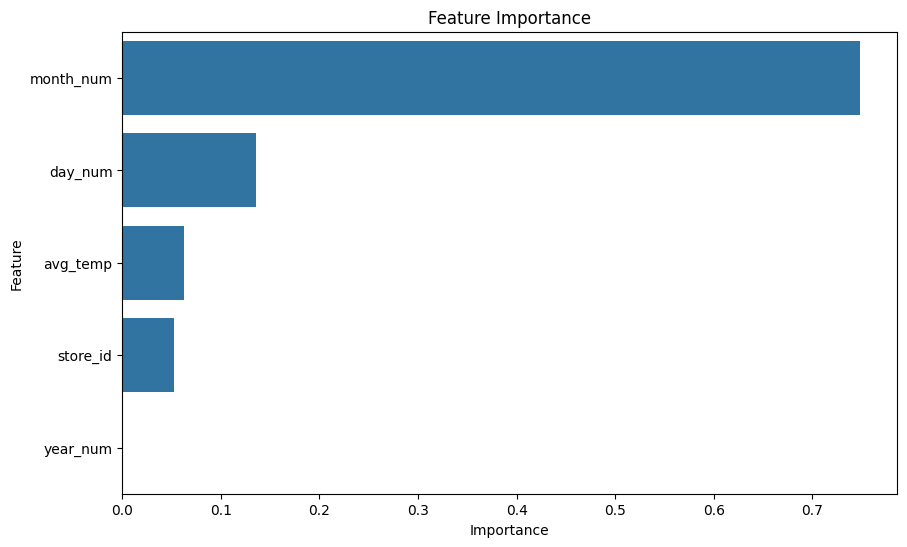

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
}).sort_values(by='importance', ascending=False)

feature_importance


plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

- The model mainly uses month_num, which means sales change a lot by month.

- day_num is also important, showing differences within the month.

- avg_temp has some effect, but it is not the main factor.

- store_id has a small impact.

- year_num has no impact because all data is from the same year.

### Model Inference (Prediction on New Data)

##### Predicting Sales for a Single Day and Store

In [20]:
new_day = pd.DataFrame({
    'store_id': [3],
    'year_num': [2023],
    'month_num': [1],
    'day_num': [3],
    'avg_temp': [6.5]
})

predicted_sale = rf_model.predict(new_day)
print("Predicted sale is:", round(predicted_sale[0], 2))

Predicted sale is: 891.42


### Future Sales Predictions for Selected Stores

In [29]:
stores = ml_df['store_id'].unique()

future_day = pd.DataFrame({
    'store_id': stores,
    'year_num': 2023,
    'month_num': 7,
    'day_num': 1,
    'avg_temp': 30.0
})

future_day['predicted_sales'] = rf_model.predict(future_day).round(2)
future_day

,store_id,year_num,month_num,day_num,avg_temp,predicted_sales
0,3,2023,7,1,30.0,1774.63
1,5,2023,7,1,30.0,1572.71
2,8,2023,7,1,30.0,1732.98


In [25]:
X_test['predicted_sales']=y_pred.round(2)
X_test['actual_sales']=y_test.round(2)

In [26]:
X_test.head()

,store_id,year_num,month_num,day_num,avg_temp,predicted_sales,actual_sales
530,8,2023,6,26,21.7875,1813.19,1746.10
478,5,2023,6,9,16.9417,1798.88,2159.08
354,3,2023,4,29,10.8188,1060.40,1124.05
531,3,2023,6,27,21.7583,2115.05,1861.55
322,5,2023,4,18,11.0167,1463.67,1164.68


### Visualization of Actual vs Predicted Sales

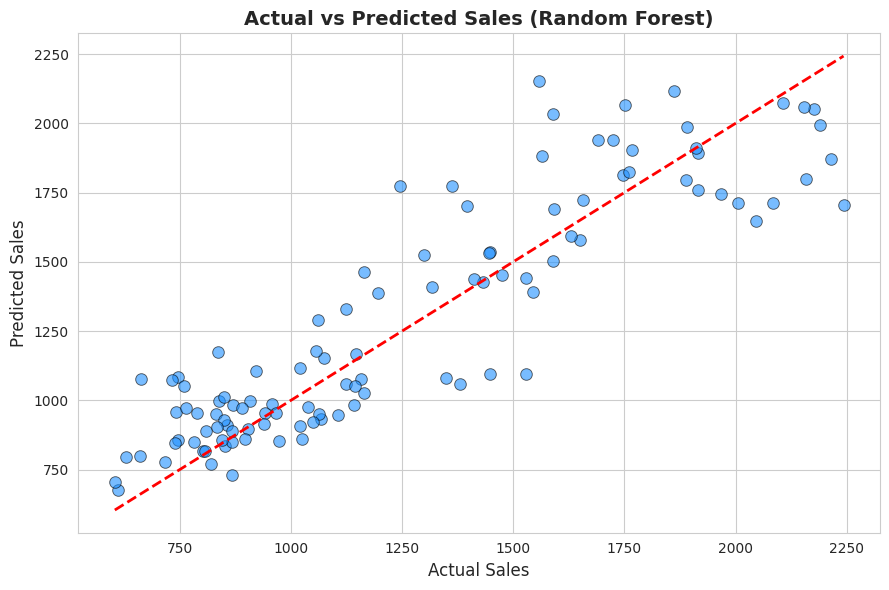

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

plt.figure(figsize=(9,6))
sns.set_style("whitegrid")

# Scatter plot
sns.scatterplot(x=y_test, y=y_pred, 
                color='dodgerblue', 
                s=70, alpha=0.6, edgecolor='k')

# 45-degree reference line
max_val = max(y_test.max(), y_pred.max())
min_val = min(y_test.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2)

plt.xlabel("Actual Sales", fontsize=12)
plt.ylabel("Predicted Sales", fontsize=12)
plt.title("Actual vs Predicted Sales (Random Forest)", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


The model provides generally good predictions, especially for average sales. 

There are slight errors in predicting very high or very low sales, but the overall trend is captured accurately.